<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
# line with noise mmsi=371415000

In [122]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.preprocessing import MinMaxScaler
import psycopg2
from random import choice
import contextily as ctx
import numpy as np
from shapely.geometry import Point, LineString, shape
from tqdm import tqdm_notebook
import numpy as np
from multiprocessing import cpu_count, Pool
from functools import partial
import datetime

In [4]:
def map_plot(df1, df2, color, figsize = (15,15)):
    df1.crs = {'init': 'epsg:4326'}
    df2.crs = {'init': 'epsg:4326'}
    ax = df1.to_crs(epsg=3857).plot(figsize=figsize,c=color[0])
    df2.to_crs(epsg=3857).plot(figsize=figsize,c=color[1], ax=ax)
    ctx.add_basemap(ax)


In [5]:
def distance_to_nearest_port(point, ports):
    return ports.geom.distance(point).min()

In [81]:
def get_outliers(series, alpha = 3):
    q25, q75 = series.quantile((0.25, 0.75))
    iqr = q75 - q25
    q_high = q75 + alpha*iqr
    q_low = q25 - alpha*iqr
    return series.loc[(series >q_high) | (series<q_low)].index

In [159]:
host    = 
db_name = 
uname   = 
pw      = 
port    = 

traj_sql = 'SELECT * FROM ais_data.dynamic_ships WHERE ts>1456839110 AND ts<1456975510  '
ports_sql = 'SELECT * FROM ports.ports_of_brittany'


con = psycopg2.connect(database=db_name, user=uname, password=pw, host=host, port = port)
traj = gpd.GeoDataFrame.from_postgis(traj_sql, con, geom_col='geom' )
ports = gpd.GeoDataFrame.from_postgis(ports_sql, con, geom_col='geom' )

con.close()


ports.geom = ports.geom.apply(lambda x: x[0])

KeyboardInterrupt: 

In [158]:
ports.memory_usage().sum()/(1024*1024)

0.0136260986328125

* Pick a sample vessel
* Sort based on ts
* Drop rows with duplicate 
* Drop outliers based on ts
* Reset and drop index col

In [112]:
sample_ves = traj.loc[traj.mmsi == 371415000]
sample_ves.sort_values(['ts'], inplace=True)
sample_ves.drop_duplicates(['ts'], inplace=True)
clean_sv = sample_ves.drop(get_outliers(sample_ves.ts, alpha=3), axis=0)
clean_sv.reset_index(inplace=True)
clean_sv.drop(['index'], axis=1, inplace=True)

/home/theo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/theo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:
clean_sv['datatime'] = pd.to_datetime(clean_sv['ts'],unit='s')

In [127]:
dt_clean_sv = clean_sv.set_index(['datatime'], drop=True, verify_integrity=True)

In [128]:
dt_clean_sv

,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom
datatime,,,,,,,,,,,
2016-03-02 10:53:34,12413781,371415000,0.0,127.0,11.1,71.0,65,-5.378398,48.042583,1456916014,POINT (-5.3783984 48.042583)
2016-03-02 10:56:54,12697289,371415000,0.0,0.0,11.5,71.0,65,-5.363332,48.046017,1456916214,POINT (-5.363332 48.046017)
2016-03-02 10:59:34,12414197,371415000,0.0,0.0,11.5,72.0,65,-5.351282,48.048534,1456916374,POINT (-5.3512816 48.048534)
2016-03-02 11:00:45,12414288,371415000,0.0,0.0,11.5,72.0,65,-5.345832,48.049633,1456916445,POINT (-5.345832 48.049633)
2016-03-02 11:00:54,12414300,371415000,0.0,0.0,11.6,73.0,65,-5.345048,48.049767,1456916454,POINT (-5.3450484 48.049767)
2016-03-02 11:01:05,12697602,371415000,0.0,0.0,11.6,74.0,64,-5.344282,48.049915,1456916465,POINT (-5.3442817 48.049915)
2016-03-02 11:01:55,12697663,371415000,0.0,127.0,11.6,69.0,65,-5.340432,48.050682,1456916515,POINT (-5.3404317 48.050682)
2016-03-02 11:03:04,12697746,371415000,0.0,-126.0,11.5,74.0,65,-5.334949,48.051850,1456916584,POINT (-5.3349485 48.05185)
2016-03-02 11:03:15,12414471,371415000,0.0,0.0,11.6,71.0,66,-5.334165,48.052000,1456916595,POINT (-5.334165 48.052)


In [153]:
upsampled = dt_clean_sv.geom.resample('60S').first()
interpolated = upsampled.interpolate(method='linear')


In [155]:
upsampled

datatime
2016-03-02 10:53:00    POINT (-5.3783984 48.042583)
2016-03-02 10:54:00                             NaN
2016-03-02 10:55:00                             NaN
2016-03-02 10:56:00     POINT (-5.363332 48.046017)
2016-03-02 10:57:00                             NaN
2016-03-02 10:58:00                             NaN
2016-03-02 10:59:00    POINT (-5.3512816 48.048534)
2016-03-02 11:00:00     POINT (-5.345832 48.049633)
2016-03-02 11:01:00    POINT (-5.3442817 48.049915)
2016-03-02 11:02:00                             NaN
2016-03-02 11:03:00     POINT (-5.3349485 48.05185)
2016-03-02 11:04:00    POINT (-5.3288484 48.053032)
2016-03-02 11:05:00    POINT (-5.3258815 48.053616)
2016-03-02 11:06:00      POINT (-5.320465 48.05465)
2016-03-02 11:07:00    POINT (-5.3164983 48.055485)
2016-03-02 11:08:00       POINT (-5.311965 48.0564)
2016-03-02 11:09:00     POINT (-5.307182 48.057365)
2016-03-02 11:10:00    POINT (-5.3020983 48.058315)
2016-03-02 11:11:00    POINT (-5.2979484 48.060066)
201

In [156]:
interpolated

datatime
2016-03-02 10:53:00    POINT (-5.3783984 48.042583)
2016-03-02 10:54:00                             NaN
2016-03-02 10:55:00                             NaN
2016-03-02 10:56:00     POINT (-5.363332 48.046017)
2016-03-02 10:57:00                             NaN
2016-03-02 10:58:00                             NaN
2016-03-02 10:59:00    POINT (-5.3512816 48.048534)
2016-03-02 11:00:00     POINT (-5.345832 48.049633)
2016-03-02 11:01:00    POINT (-5.3442817 48.049915)
2016-03-02 11:02:00                             NaN
2016-03-02 11:03:00     POINT (-5.3349485 48.05185)
2016-03-02 11:04:00    POINT (-5.3288484 48.053032)
2016-03-02 11:05:00    POINT (-5.3258815 48.053616)
2016-03-02 11:06:00      POINT (-5.320465 48.05465)
2016-03-02 11:07:00    POINT (-5.3164983 48.055485)
2016-03-02 11:08:00       POINT (-5.311965 48.0564)
2016-03-02 11:09:00     POINT (-5.307182 48.057365)
2016-03-02 11:10:00    POINT (-5.3020983 48.058315)
2016-03-02 11:11:00    POINT (-5.2979484 48.060066)
201

In [7]:
static = traj.loc[traj.speed == 0]
almost_static = traj.loc[(traj.speed < 1) & (traj.speed > 0)]
static.reset_index()
almost_static.reset_index()

,index,id,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom
0,47,12342909,228394000,7.0,-127.0,0.3,316.9,511,-4.854757,48.107487,1456839237,POINT (-4.854757 48.107487)
1,50,12342912,227002630,0.0,0.0,0.1,119.5,199,-4.848552,48.039030,1456839241,POINT (-4.8485518 48.03903)
2,63,12342986,227574020,15.0,-127.0,0.1,267.1,511,-4.496570,48.382374,1456839320,POINT (-4.49657 48.382374)
3,64,12342987,227002630,0.0,0.0,0.1,219.7,198,-4.848558,48.039036,1456839322,POINT (-4.8485584 48.039036)
4,81,12343004,228394000,7.0,-127.0,0.6,299.5,511,-4.855467,48.107500,1456839337,POINT (-4.855467 48.1075)
5,83,12343006,227574020,15.0,-127.0,0.1,332.3,511,-4.496571,48.382374,1456839340,POINT (-4.4965715 48.382374)
6,94,12343017,227002630,0.0,0.0,0.1,180.0,198,-4.848558,48.039040,1456839352,POINT (-4.8485584 48.03904)
7,109,12343032,227006750,0.0,127.0,0.1,307.3,259,-4.484489,48.381160,1456839366,POINT (-4.4844885 48.38116)
8,151,12343135,227002630,0.0,0.0,0.1,271.9,199,-4.848582,48.039080,1456839462,POINT (-4.848582 48.03908)
9,163,12343147,227002630,0.0,0.0,0.1,286.6,199,-4.848592,48.039100,1456839472,POINT (-4.848592 48.0391)


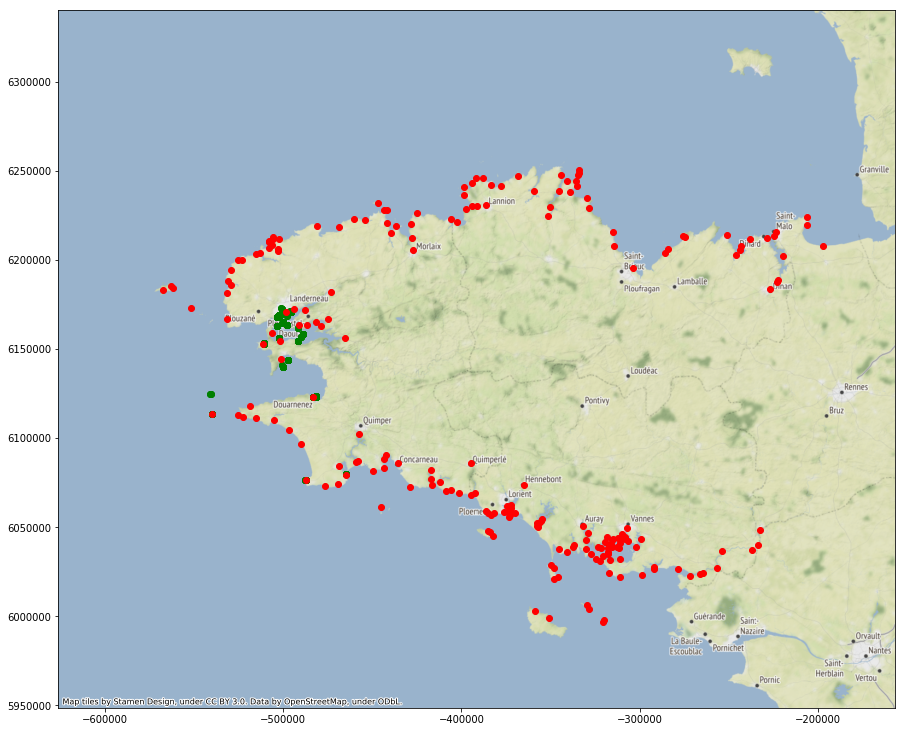

In [9]:
map_plot(static, ports, ['g', 'r'], (15,15))

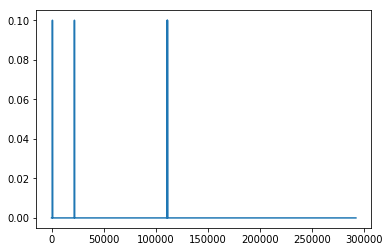

In [89]:
traj.loc[traj['mmsi'] == choice(traj.mmsi.unique())].speed.plot()

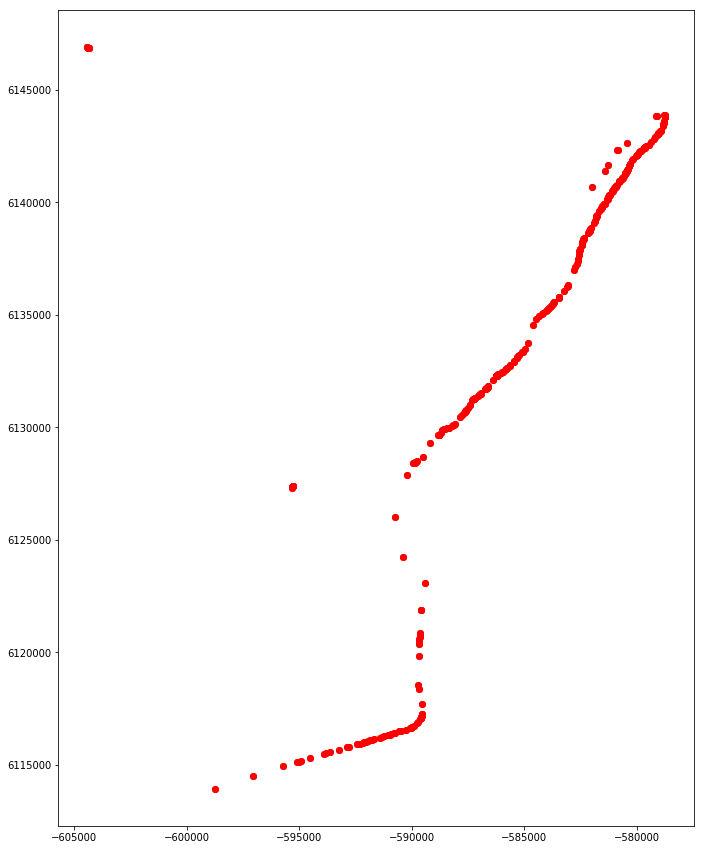

In [27]:
sample_ves.crs = {'init': 'epsg:4326'}
tmp = sample_ves.to_crs(epsg=3857).plot(figsize=(15, 15),c='r')

In [53]:
almost_static['distance_to_nearest_port'] = almost_static.geom.apply(distance_to_nearest_port, args=(ports,))

/home/theo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
almost_static.distance_to_nearest_port.max()

0.16155259593051566